In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'project': 'qalf',
    'domain': 'tacred',
    'relation': 'org_top_members_employees',
    'splits': [0,1],
    'supervision': 'generative',
#     'max_train': 2000,
#     'max_lfs': 1,
#     'learn_deps': True,
    'gen_model_search_space': 10,
    'gen_init_params': {
        'lf_propensity'         : True,
        'class_prior'           : False,
        'lf_class_propensity'   : False,
        'seed'                  : False,
    },
#     'gen_params_default': {
#         'step_size'     : 0.0001,
#         'decay'         : 0.90,
#         'reg_param'     : 0.50,
#         'epochs'        : 5,
#     },
    'disc_params_range': {
        'lr'        : [1e-1, 1e-2, 1e-3, 1e-4],
        'dim'       : [32, 64, 128],
        'batch_size': [32, 64, 128],
        'l1_penalty': [0, 1e-5, 1e-4, 1e-3, 1e-2], 
        'l2_penalty': [0, 1e-5, 1e-4, 1e-3, 1e-2], 
    },
    'disc_params_default': {
#         'l1_penalty': 1.0,
#         'l2_penalty': 1.0,
#         'lr':         0.01,
        'dim':        50,
#         'n_epochs':   20,
#         'dropout':    0.5,
#         'rebalance':  False,
#         'batch_size': 128,
#         'max_sentence_length': 100,
#         'print_freq': 1,
    },
    'disc_model_class': 'logreg',    
    'disc_model_search_space': 10,
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = (config['project'] + '_' + config['domain'] + 
                   ('_' + config['relation'] if config['relation'] else '') +
                   ('_debug' if config.get('debug', False) else ''))
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///qalf_tacred_org_top_members_employees.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'], config['project'])
pipe = pipeline(session, candidate_class, config)

Overwriting domain=None to domain=tacred
Overwriting batch_size=128 to batch_size=64
Overwriting n_epochs=20 to n_epochs=25
Overwriting l2_penalty=1.0 to l2_penalty=0
Overwriting l1_penalty=1.0 to l1_penalty=0
Overwriting seed=123 to seed=False
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting project=babble to project=qalf
Overwriting splits=[0, 1, 2] to splits=[0, 1]
Using TacredQalfPipeline object.


In [5]:
for split in config['splits']:
    num_cands = pipe.session.query(pipe.candidate_class).filter(
        pipe.candidate_class.split == split).count()
    print("Split {}: {} Candidates".format(split, num_cands))

Split 0: 7824 Candidates
Split 1: 2039 Candidates


In [6]:
# %time pipe.parse()

In [7]:
# %time pipe.extract()

In [8]:
# %time pipe.load_gold()

In [9]:
# %time pipe.featurize()

In [10]:
# %time pipe.collect()

In [11]:
# %time pipe.label()

In [12]:
from snorkel.annotations import load_gold_labels, load_label_matrix
L_train = load_label_matrix(pipe.session, split=0)
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_train.lf_stats(session, labels=L_gold_train)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
Who is the president of ENT:subj? (0.95 -> +1),0,0.112730,0.101866,0.000383,650,232,0,0,0.736961
Who is the head of ENT:subj? (0.95 -> +1),1,0.117459,0.110046,0.000128,654,265,0,0,0.711643
Who is the CEO of ENT:subj? (0.95 -> +1),2,0.113625,0.109407,0.000000,661,228,0,0,0.743532
Who is an executive at ENT:subj? (0.95 -> +1),3,0.163216,0.150179,0.000000,925,352,0,0,0.724354
Who is a manager at ENT:subj? (0.95 -> +1),4,0.126789,0.113625,0.000256,645,347,0,0,0.650202
Who is the president of ENT:subj? (<0.10 -> -1),5,0.340619,0.332950,0.000256,0,0,180,2485,0.932458
Who is the head of ENT:subj? (<0.10 -> -1),6,0.329499,0.324131,0.000383,0,0,179,2399,0.930566
Who is the CEO of ENT:subj? (<0.10 -> -1),7,0.347904,0.340746,0.000383,0,0,172,2550,0.936811
Who is an executive at ENT:subj? (<0.10 -> -1),8,0.342791,0.336273,0.000000,0,0,159,2523,0.940716
Who is a manager at ENT:subj? (<0.10 -> -1),9,0.334867,0.326943,0.000383,0,0,182,2438,0.930534


In [24]:
from snorkel.annotations import load_gold_labels, load_label_matrix
L_dev = load_label_matrix(pipe.session, split=1)
L_gold_dev   = load_gold_labels(session, annotator_name='gold', split=1)
L_dev.lf_stats(session, labels=L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
Who is the president of ENT:subj? (0.95 -> +1),0,0.170672,0.163806,0.00000,266,82,0,0,0.764368
Who is the head of ENT:subj? (0.95 -> +1),1,0.212359,0.203531,0.00000,317,116,0,0,0.732102
Who is the CEO of ENT:subj? (0.95 -> +1),2,0.202060,0.191270,0.00049,306,106,0,0,0.742718
Who is an executive at ENT:subj? (0.95 -> +1),3,0.251594,0.234919,0.00000,388,125,0,0,0.756335
Who is a manager at ENT:subj? (0.95 -> +1),4,0.190780,0.182442,0.00049,285,104,0,0,0.732648
Who is the president of ENT:subj? (<0.10 -> -1),5,0.273173,0.269250,0.00000,0,0,42,515,0.924596
Who is the head of ENT:subj? (<0.10 -> -1),6,0.266307,0.261403,0.00049,0,0,41,502,0.924494
Who is the CEO of ENT:subj? (<0.10 -> -1),7,0.280039,0.276116,0.00049,0,0,45,526,0.921191
Who is an executive at ENT:subj? (<0.10 -> -1),8,0.283472,0.274154,0.00000,0,0,44,534,0.923875
Who is a manager at ENT:subj? (<0.10 -> -1),9,0.271211,0.261403,0.00000,0,0,47,506,0.915009


Using L_train: <7824x10 sparse matrix of type '<type 'numpy.int64'>'
	with 18226 stored elements in Compressed Sparse Row format>
Using L_gold_train: <7824x1 sparse matrix of type '<type 'numpy.int64'>'
	with 7824 stored elements in Compressed Sparse Row format>
Positive Fraction: 27.3%

Using L_dev: <2039x10 sparse matrix of type '<type 'numpy.int64'>'
	with 4897 stored elements in Compressed Sparse Row format>
Using L_gold_dev: <2039x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2039 stored elements in Compressed Sparse Row format>
Positive Fraction: 31.1%

[1] Testing epochs = 25, step_size = 1.00e-02, reg_param = 1.00e-02, decay = 9.00e-01
Inferred cardinality: 2
[GenerativeModel] F-1.0 Score: 0.0
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing epochs = 50, step_size = 1.00e-04, reg_param = 0.00e+00, decay = 9.50e-01
Inferred cardinality: 2
[GenerativeModel] F-1.0 Score: 0.686495176849
[GenerativeModel] Model saved as <GenerativeModel_1>.
[3] Testing epochs

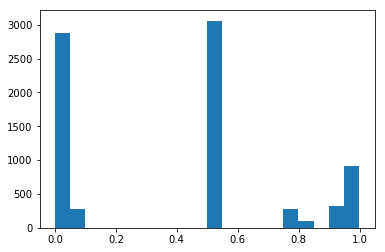

Saved 7824 marginals
CPU times: user 2min 37s, sys: 945 ms, total: 2min 38s
Wall time: 2min 38s


In [14]:
%time pipe.supervise()

In [23]:
tp, fp, tn, fn = pipe.gen_model.error_analysis(
    pipe.session, L_dev, L_gold_dev, b=0.5, display=True)

Scores (Un-adjusted)
Pos. class accuracy: 0.672
Neg. class accuracy: 0.87
Precision            0.701
Recall               0.672
F1                   0.686
----------------------------------------
TP: 427 | FP: 182 | TN: 1222 | FN: 208



(7824,)


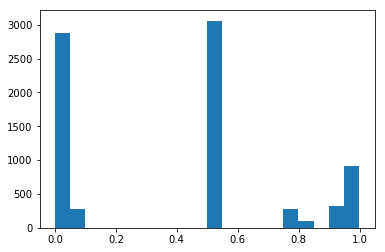

### [7.1] Begin training discriminative model
[1] Testing dim = 32, l2_penalty = 1.00e-02, lr = 1.00e-01, l1_penalty = 1.00e-05, batch_size = 32
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=4766  #epochs=25  batch size=32
[SparseLogi...] Epoch 0 (0.29s) 	Train Loss=7.579	Dev Loss=17.420	Dev F1=64.42
[SparseLogi...] Epoch 1 (0.71s) 	Train Loss=23.093	Dev Loss=29.771	Dev F1=63.31
[SparseLogi...] Epoch 2 (1.11s) 	Train Loss=34.310	Dev Loss=41.294	Dev F1=62.43
[SparseLogi...] Epoch 3 (1.53s) 	Train Loss=45.588	Dev Loss=49.840	Dev F1=63.03
[SparseLogi...] Epoch 4 (1.95s) 	Train Loss=52.497	Dev Loss=57.482	Dev F1=62.43
[SparseLogi...] Epoch 5 (2.35s) 	Train Loss=60.592	Dev Loss=64.858	Dev F1=63.78
[SparseLogi...] Epoch 6 (2.75s) 	Train Loss=68.904	Dev Loss=73.373	Dev F1=63.85
[SparseLogi...] Epoch 7 (3.17s) 	Train Loss=77.751	Dev Loss=82.397	Dev F1=60.71
[SparseLogi...] Epoch 8 (3.59s) 	Train Loss=85.375	Dev Loss=90.210	Dev F1=62.72
[SparseLogi...] Epoch 9 (4.

In [15]:
%time pipe.classify()

## Scratch Space

In [16]:
# from snorkel.models import Sentence
# s = pipe.session.query(Sentence).first()
# s.pos_tags

In [17]:
# from spacy.lemmatizer import Lemmatizer
# from spacy.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
# lemmas = lemmatizer(u'ducks', u'NOUN')
# print(lemmas)

In [18]:
# from spacy.lemmatizer import Lemmatizer
# lemmatizer = Lemmatizer()